In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import folium

import json
from loguru import logger
from pathlib import Path

from geowrangler.datasets import geofabrik

import sys

sys.path.append("../../../")  # include parent directory
from src.vector_utils import *

/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Assess OSM for relevant classes

This notebook's purpose is to assess the available datasets and classes we can get from OpenStreetMap for the year 2022. The main objectives are to:
- Assess completeness across the target cities;
- Establish the necessary functions for incoming data for the following years; and
- Determine whether other datasets are needed to be used

### Input

- Administrative boundaries
- OSM POIs
- Geoportal Health Facilities *(came after spot-checking OSM Health POIs)*

### Output

**Features output**

- POI counts
- Nearest distances to POI classes 

**Notebook output**

- Table of extracted features
- Folium maps, plots


### Set-up Input Parameters

In [9]:
# data directories
DATA_DIR = Path("../../../data/")
SRC_DIR = Path("../../../src/")
ADMIN_FPATH = DATA_DIR / "01-admin-bounds"
RAW_FPATH = DATA_DIR / "02-raw"
PROCESSED_FPATH = DATA_DIR / "03-processed"
OUTPUT_FPATH = DATA_DIR / "04-output"
GIS_FPATH = DATA_DIR / "05-gis"

In [4]:
# Parameters

# POI types of OSM
# tags taken from https://wiki.openstreetmap.org/wiki/Map_features
poi_file = Path(SRC_DIR / "osm_poi_categories.json")

with open(poi_file, "r") as f:
    data = json.load(f)

POI_TYPES_NEEDED = []
for category in data:
    POI_TYPES_NEEDED += data[category]

# change this parameter to download for other years
OSM_YEAR = "2022"
OSM_COUNTRY = "philippines"

In [5]:
# how many needed types
len(POI_TYPES_NEEDED)

58

### Load AOIs and Generated SHP files

In [24]:
# Load the administrative boundaries for the 12 cities
admin_bounds_gdf = gpd.read_file(ADMIN_FPATH / "target_admin_bounds.shp")
admin_bounds_gdf.head(2)

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


In [14]:
# Load generated osm poi features for 2022
osm_poi_feats_gdf = pd.read_csv(OUTPUT_FPATH / "osm" / "osm_poi_features_2022.csv")
osm_poi_feats_gdf.head(3)

,ADM4_PCODE,date,freq,poi_count,osm_poi_clinic_count,osm_poi_clinic_nearest,osm_poi_dentist_count,osm_poi_dentist_nearest,osm_poi_doctors_count,osm_poi_doctors_nearest,...,osm_poi_toilet_count,osm_poi_toilet_nearest,osm_poi_recycling_count,osm_poi_recycling_nearest,osm_poi_waste_basket_count,osm_poi_waste_basket_nearest,osm_poi_wastewater_plant_count,osm_poi_wastewater_plant_nearest,osm_poi_waste_transfer_station_count,osm_poi_waste_transfer_station_nearest
0,PH015518016,2022-01-01,Y,0.0,0.0,10000.0,0.0,1323.047447,0.0,1661.884583,...,0.0,5993.655956,0.0,2486.499185,0.0,10000.0,0.0,10000.0,0.0,10000.0
1,PH015518031,2022-01-01,Y,82.0,0.0,10000.0,1.0,0.000000,1.0,0.000000,...,0.0,3736.276540,0.0,79.395847,0.0,10000.0,0.0,10000.0,0.0,10000.0
2,PH015518022,2022-01-01,Y,116.0,0.0,10000.0,1.0,0.000000,1.0,0.000000,...,0.0,4216.614031,0.0,1752.273027,0.0,10000.0,0.0,10000.0,0.0,10000.0


## 1. Check OSM availability using Metro Manila

Metro Manila will be used to assess completeness of POI types for the whole PH. The available needed POI types that are present in Metro Manila were filtered in QGIS beforehand.

In [8]:
ncr_test = gpd.read_file(DATA_DIR / "03-processed" / "metro_manila_osm_pois.geojson")
ncr_test.head()

,osm_id,code,fclass,name,field_1,ADM1_EN,geometry
0,21717820,2907,camera_surveillance,None,False,National Capital Region,POINT (121.02120 14.57608)
1,21717872,2722,museum,Ayala Museum,False,National Capital Region,POINT (121.02324 14.55358)
2,24078301,2402,motel,Sogo Grand Hotel,False,National Capital Region,POINT (121.04515 14.56449)
3,24078959,2907,camera_surveillance,None,False,National Capital Region,POINT (121.05945 14.60098)
4,24797511,2542,bicycle_shop,Christine Sports Cycle Marketing,False,National Capital Region,POINT (120.99506 14.55224)


In [9]:
ncr_poi_summary = pd.read_csv(
    DATA_DIR / "03-processed" / "osm_pois_filtered_avilability.csv"
)
ncr_poi_summary.sort_values(by="count", ascending=False)

,fclass,count
4,bank,2452
13,convenience,1899
7,pharmacy,971
28,recycling,751
1,school,570
11,atm,474
5,supermarket,420
23,dentist,272
21,toilet,269
15,police,210


Check what POI types are missing in Metro Manila.

In [10]:
available_poi_types = ncr_test["fclass"].unique().tolist()
lacking = list(set(POI_TYPES_NEEDED) - set(available_poi_types))
lacking

['line',
 'connection',
 'service_device',
 'insulator',
 'pole',
 'data_center',
 'cable',
 'distribution_point',
 'generator',
 'water_mill',
 'sanitary_dump_station',
 'compensator',
 'waste_transfer_station',
 'busbar',
 'substation',
 'transformer',
 'connection_point',
 'plant',
 'exchange',
 'bay',
 'minor_line',
 'portal',
 'converter',
 'clinic']

## 2. Map POIs in Target Areas

- per city and per barangay visualization
- points (color coded based on category)
- visualize the counts per category for sample cities

In [11]:
osm_poi_feats_gdf = osm_poi_feats_gdf.set_geometry("geometry")

Visualize through a chloropleth the total POI counts for each target barangay.

In [12]:
# map of poi counts
GOOGLE_BASEMAP = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=True,
    control=True,
    show=True,
)

poi_count_map = osm_poi_feats_gdf.explore(
    column="poi_count",
    cmap="Wistia",
    tooltip=["region_name", "province_name", "city_name", "barangay_name", "poi_count"],
)

GOOGLE_BASEMAP.add_to(poi_count_map)

# UNCOMMENT TO DISPLAY MAP
# poi_count_map

In [13]:
# UNCOMMENT TO SAVE FOLIUM MAP
# poi_count_map.save(GIS_FPATH / "osm_poi_count_map.html")

Based on the map above, there is a number of barangays that have 0 of the POIs we are looking for.

Investigate the barangays/cities  that have none of the target POIs.

In [14]:
osm = geofabrik.OsmDataManager(cache_dir="../../../data/02-raw/")
osm_pois_2022 = osm.load_pois(region=OSM_COUNTRY, year=OSM_YEAR, use_cache=True)

2023-06-05 21:44:17.076 | INFO     | geowrangler.datasets.geofabrik:download_osm_region_data:128 - OSM Data: Cached data available for philippines at ../../../data/02-raw/osm/philippines-220101-free.shp.zip? True
2023-06-05 21:44:17.077 | DEBUG    | geowrangler.datasets.geofabrik:load_pois:222 - OSM POIs for philippines and year 2022 being loaded from ../../../data/02-raw/osm/philippines-220101-free.shp.zip


In [15]:
joined_target_poi_all = gpd.sjoin(osm_pois_2022, admin_bounds_gdf)
joined_target_poi_all = joined_target_poi_all[
    joined_target_poi_all["fclass"].isin(POI_TYPES_NEEDED)
]

In [16]:
# do another folium map of all pois in the target areas

GOOGLE_BASEMAP = folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Satellite",
    overlay=True,
    control=True,
    show=True,
)

pois_all = joined_target_poi_all.explore(column="fclass")

GOOGLE_BASEMAP.add_to(pois_all)
#
#  pois_all

### 2.1 POI types distributions

Check which POI types are the highest in some of the target cities that have high and low POI counts.

In [17]:
filtered_join = joined_target_poi_all[
    joined_target_poi_all["fclass"].isin(POI_TYPES_NEEDED)
]

davao_city = filtered_join[filtered_join["city_name"] == "Davao City"]
munti_city = filtered_join[filtered_join["city_name"] == "City of Muntinlupa"]
palayan_city = filtered_join[filtered_join["city_name"] == "Palayan City"]
navotas_city = filtered_join[filtered_join["city_name"] == "City of Navotas"]

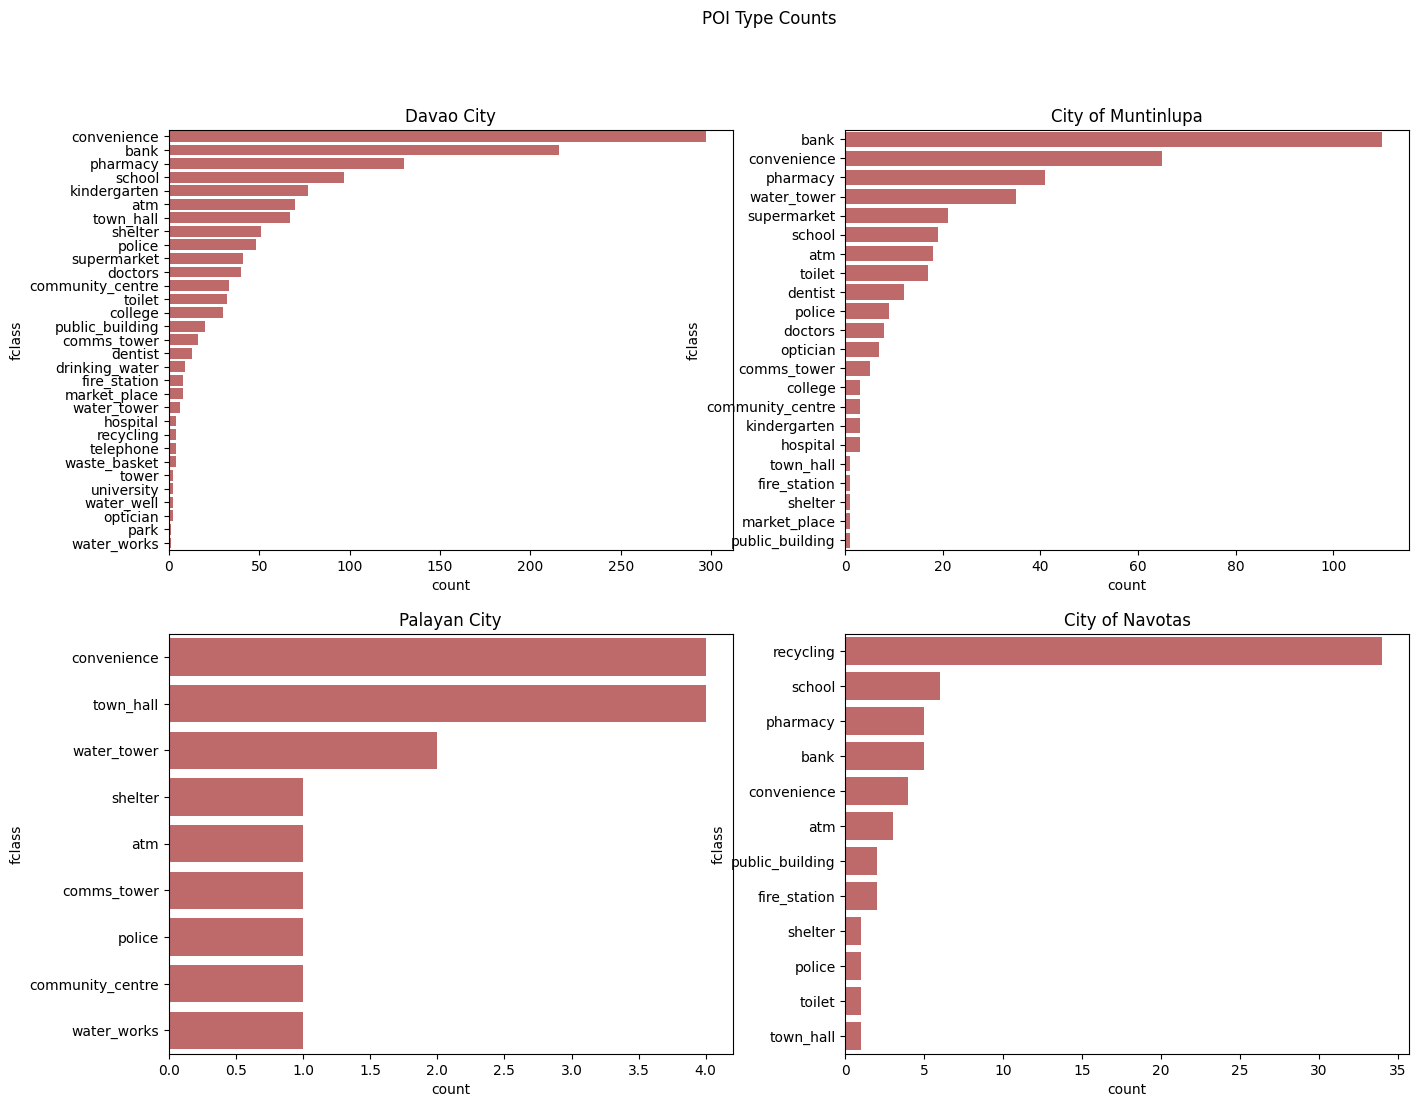

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("POI Type Counts")

city_to_viz = [davao_city, munti_city, palayan_city, navotas_city]

for city, ax in zip(city_to_viz, axs.flat):
    sns.countplot(
        ax=ax,
        data=city,
        y="fclass",
        order=city["fclass"].value_counts().index,
        color="indianred",
    )
    ax.set_title(city["city_name"].iloc[0])

## 3. Study each POI category

In [19]:
# create categories
health_pois = data["health"]
crit_lifelines = data["crit_lifelines"]
power_pois = data["power"]
telco_pois = data["telco"]
water_pois = data["water"]
sanitation_pois = data["sanitation"]

# get the feature cols in the OSM POI features table
def get_poi_category_cols(poi_name_list, df=osm_poi_feats_gdf):
    poi_cols = [x for x in df.columns[df.columns.str.contains("|".join(poi_name_list))]]
    return poi_cols


health_cols = get_poi_category_cols(health_pois)
crit_cols = get_poi_category_cols(crit_lifelines)
power_cols = get_poi_category_cols(power_pois)
telco_cols = get_poi_category_cols(telco_pois)
water_cols = get_poi_category_cols(water_pois)
sanitation_cols = get_poi_category_cols(sanitation_pois)

admin_cols = ["region_name", "province_name", "city_name", "barangay_name", "geometry"]

### 3.1 Spot-check health

Compare OSM Health tags availability to DOH's Geoportal.

In [20]:
osm_poi_feats_gdf

,region_name,region_code,province_name,province_code,city_name,city_code,barangay_name,barangay_psgc_code,osm_year,poi_count,...,osm_poi_toilet_nearest,osm_poi_recycling_count,osm_poi_recycling_nearest,osm_poi_waste_basket_count,osm_poi_waste_basket_nearest,osm_poi_wastewater_plant_count,osm_poi_wastewater_plant_nearest,osm_poi_waste_transfer_station_count,osm_poi_waste_transfer_station_nearest,geometry
0,National Capital Region,PH130000000,"NCR, Fourth District",PH137600000,City of Muntinlupa,PH137603000,Alabang,PH137603001,2022,373.0,...,0.000000,0.0,3534.852780,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((121.05364 14.42508, 121.05394 14.424..."
1,National Capital Region,PH130000000,"NCR, Second District",PH137400000,City of Mandaluyong,PH137401000,Highway Hills,PH137401013,2022,202.0,...,499.731170,0.0,141.063412,0.0,2397.074322,0.0,6342.812598,0.0,10000.0,"POLYGON ((121.05614 14.57903, 121.05712 14.578..."
2,National Capital Region,PH130000000,"NCR, Fourth District",PH137600000,City of Muntinlupa,PH137603000,New Alabang Village,PH137603009,2022,197.0,...,874.909269,0.0,2264.419248,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((121.03128 14.42464, 121.03163 14.424..."
3,Region XI,PH110000000,Davao del Sur,PH112400000,Davao City,PH112402000,Bucana,PH112402020,2022,186.0,...,216.545604,1.0,0.000000,0.0,3862.906576,0.0,10000.000000,0.0,10000.0,"POLYGON ((125.60493 7.06428, 125.60548 7.06383..."
4,National Capital Region,PH130000000,"NCR, Second District",PH137400000,City of Mandaluyong,PH137401000,Wack-wack Greenhills,PH137401027,2022,156.0,...,40.982354,3.0,0.000000,0.0,3394.299365,0.0,4916.145563,0.0,10000.0,"POLYGON ((121.05959 14.60027, 121.05965 14.599..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Region VI,PH060000000,Iloilo,PH063000000,Iloilo City,PH063022000,Mansaya-Lapuz,PH063022105,2022,0.0,...,1163.341438,0.0,10000.000000,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((122.58780 10.70184, 122.58786 10.701..."
875,Region VI,PH060000000,Iloilo,PH063000000,Iloilo City,PH063022000,Hinactacan,PH063022068,2022,0.0,...,2304.015816,0.0,10000.000000,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((122.58621 10.74522, 122.58865 10.743..."
876,Region VI,PH060000000,Iloilo,PH063000000,Iloilo City,PH063022000,Jalandoni-Wilson,PH063022074,2022,0.0,...,503.062658,0.0,10000.000000,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((122.56115 10.69578, 122.56163 10.695..."
877,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 67 - Bariis (Bgy. 46),PH050506044,2022,0.0,...,10000.000000,0.0,10000.000000,0.0,10000.000000,0.0,10000.000000,0.0,10000.0,"POLYGON ((123.75267 13.03616, 123.77560 13.028..."


In [21]:
health_availability = osm_poi_feats_gdf[admin_cols + health_cols]

In [22]:
(health_availability == 0).all()

region_name                 False
province_name               False
city_name                   False
barangay_name               False
geometry                    False
osm_poi_clinic_count         True
osm_poi_clinic_nearest      False
osm_poi_dentist_count       False
osm_poi_dentist_nearest     False
osm_poi_doctors_count       False
osm_poi_doctors_nearest     False
osm_poi_hospital_count      False
osm_poi_hospital_nearest    False
osm_poi_optician_count      False
osm_poi_optician_nearest    False
osm_poi_pharmacy_count      False
osm_poi_pharmacy_nearest    False
dtype: bool

In [24]:
health_availability = health_availability.drop(
    columns=["osm_poi_clinic_count", "osm_poi_clinic_nearest"]
)
health_availability

,region_name,province_name,city_name,barangay_name,geometry,osm_poi_dentist_count,osm_poi_dentist_nearest,osm_poi_doctors_count,osm_poi_doctors_nearest,osm_poi_hospital_count,osm_poi_hospital_nearest,osm_poi_optician_count,osm_poi_optician_nearest,osm_poi_pharmacy_count,osm_poi_pharmacy_nearest
0,National Capital Region,"NCR, Fourth District",City of Muntinlupa,Alabang,"POLYGON ((121.05364 14.42508, 121.05394 14.424...",3.0,0.000000,5.0,0.000000,1.0,0.000000,4.0,0.000000,16.0,0.000000
1,National Capital Region,"NCR, Second District",City of Mandaluyong,Highway Hills,"POLYGON ((121.05614 14.57903, 121.05712 14.578...",3.0,0.000000,1.0,0.000000,0.0,2768.414322,0.0,693.992914,5.0,0.000000
2,National Capital Region,"NCR, Fourth District",City of Muntinlupa,New Alabang Village,"POLYGON ((121.03128 14.42464, 121.03163 14.424...",0.0,457.618159,1.0,0.000000,0.0,1529.619915,0.0,208.061678,4.0,0.000000
3,Region XI,Davao del Sur,Davao City,Bucana,"POLYGON ((125.60493 7.06428, 125.60548 7.06383...",1.0,0.000000,0.0,146.171320,0.0,779.981957,0.0,1175.457721,7.0,0.000000
4,National Capital Region,"NCR, Second District",City of Mandaluyong,Wack-wack Greenhills,"POLYGON ((121.05959 14.60027, 121.05965 14.599...",1.0,0.000000,1.0,0.000000,0.0,1057.778822,0.0,651.111363,7.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Region VI,Iloilo,Iloilo City,Mansaya-Lapuz,"POLYGON ((122.58780 10.70184, 122.58786 10.701...",0.0,4950.343485,0.0,1700.742365,0.0,2929.863627,0.0,1342.705887,0.0,593.014356
875,Region VI,Iloilo,Iloilo City,Hinactacan,"POLYGON ((122.58621 10.74522, 122.58865 10.743...",0.0,4528.801785,0.0,3405.495004,0.0,2675.052396,0.0,3979.484402,0.0,1937.599192
876,Region VI,Iloilo,Iloilo City,Jalandoni-Wilson,"POLYGON ((122.56115 10.69578, 122.56163 10.695...",0.0,3165.714588,0.0,130.617977,0.0,2044.838637,0.0,659.187189,0.0,49.782448
877,Region V,Albay,Legazpi City,Bgy. 67 - Bariis (Bgy. 46),"POLYGON ((123.75267 13.03616, 123.77560 13.028...",0.0,10000.000000,0.0,10000.000000,0.0,3922.009052,0.0,10000.000000,0.0,10000.000000


In [25]:
health_availability.describe()

,osm_poi_dentist_count,osm_poi_dentist_nearest,osm_poi_doctors_count,osm_poi_doctors_nearest,osm_poi_hospital_count,osm_poi_hospital_nearest,osm_poi_optician_count,osm_poi_optician_nearest,osm_poi_pharmacy_count,osm_poi_pharmacy_nearest
count,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000
mean,0.088737,3283.455385,0.094425,2560.039378,0.020478,3603.145624,0.026166,4710.299283,0.588168,1882.071930
std,0.392235,3545.202909,0.380568,3403.746020,0.149530,3398.815020,0.239585,4046.257264,1.532085,3230.325524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,428.241133,0.000000,337.104023,0.000000,1140.483393,0.000000,950.776510,0.000000,7.657771
50%,0.000000,1828.051686,0.000000,956.731964,0.000000,2153.014636,0.000000,3045.584421,0.000000,262.932890
75%,0.000000,4913.836601,0.000000,3040.874086,0.000000,4933.610537,0.000000,10000.000000,0.000000,1720.985551
max,4.000000,10000.000000,5.000000,10000.000000,2.000000,10000.000000,4.000000,10000.000000,16.000000,10000.000000


Total count of the health classes. Surprisingly, hospital count is just 18 which is unrealistic for 12 cities.

In [76]:
def get_count_cols(df):
    count_cols = [x for x in df.columns[df.columns.str.contains("_count")]]
    return count_cols


def get_nearest_cols(df):
    nearest_cols = [x for x in df.columns[df.columns.str.contains("_nearest")]]
    return nearest_cols

In [28]:
count_cols = get_count_cols(health_availability)
health_availability[count_cols].sum()

osm_poi_dentist_count      78.0
osm_poi_doctors_count      83.0
osm_poi_hospital_count     18.0
osm_poi_optician_count     23.0
osm_poi_pharmacy_count    517.0
dtype: float64

In [29]:
health_availability[admin_cols + count_cols].groupby("city_name").sum()

/tmp/ipykernel_2368/2815251876.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  health_availability[admin_cols + count_cols].groupby("city_name").sum()


,osm_poi_dentist_count,osm_poi_doctors_count,osm_poi_hospital_count,osm_poi_optician_count,osm_poi_pharmacy_count
city_name,,,,,
Cagayan de Oro City,10.0,3.0,3.0,0.0,54.0
City of Mandaluyong,15.0,5.0,0.0,1.0,41.0
City of Muntinlupa,12.0,8.0,3.0,7.0,41.0
City of Navotas,0.0,0.0,0.0,0.0,5.0
Dagupan City,12.0,4.0,1.0,5.0,49.0
Davao City,13.0,40.0,4.0,2.0,130.0
Iloilo City,2.0,8.0,3.0,3.0,71.0
Legazpi City,5.0,2.0,0.0,2.0,14.0
Mandaue City,1.0,6.0,1.0,0.0,36.0


### Compare Health Facilities from Geoportal

In [78]:
doh_health = gpd.read_file(
    RAW_FPATH / "philippines_healthfacilities.gpkg", driver="GPKG"
)
doh_health.head()

,id,facilityco,healthfaci,typeofheal,barangay,municipali,province,region,status,address,style,geometry
0,1.0,DOH000000000002277,Calvario Barangay Health Station,Barangay Health Station,Calvario,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.98987 6.65182)
1,2.0,DOH000000000010319,Cabunbata Barangay Health Station,Barangay Health Station,Cabunbata,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.96630 6.67152)
2,3.0,DOH000000000001601,Begang Barangay Health Station,Barangay Health Station,Begang,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (122.01392 6.68954)
3,4.0,DOH000000000010340,Busay Barangay Health Station,Barangay Health Station,Busay,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (122.00549 6.69013)
4,5.0,DOH000000000010310,Sumagdang Barangay Health Station,Barangay Health Station,Sumagdang,City Of Isabela,City Of Isabela (not A Province),REGION IX (ZAMBOANGA PENINSULA),None,None,Barangay Health Station,POINT (121.95776 6.69125)


In [79]:
doh_health.shape

(23676, 12)

In [80]:
# filter to target cities
target_cities = [
    "Navotas",
    "Mandaluyong",
    "Muntinlupa",
    "Dagupan City",
    "Palayan City",
    "Legazpi City",
    "Iloilo City",
    "Mandaue City",
    "Tacloban City",
    "Zamboanga City",
    "Cagayan de Oro City",
    "Davao City",
]
filtered_doh = doh_health[
    doh_health["municipali"].str.contains("|".join(target_cities), case=False)
]

In [81]:
# check if it contains the target cities
filtered_doh["municipali"].unique()

array(['Zamboanga City', 'Cagayan De Oro City (Capital)', 'MANDAUE CITY',
       'ILOILO CITY (CAPITAL)', 'ILOILO CITY (CAPITAL)*', 'DAGUPAN CITY',
       'MANDALUYONG', 'NAVOTAS', 'MUNTINLUPA CITY', 'PALAYAN CITY',
       'DAVAO CITY', 'TACLOBAN CITY (CAPITAL)', 'LEGAZPI CITY (CAPITAL)'],
      dtype=object)

In [82]:
# already way more than the OSM
filtered_doh.shape

(727, 12)

Below are the types of health facilities available from geoportal. Classes are much clearer compared to OSM POIs. The only good thing from OSM POIs are the presence of pharmacies which do not seem to be included here in the Geoportal. 

In [83]:
filtered_doh["typeofheal"].value_counts()

Barangay Health Station                           417
Rural Health Unit                                 119
Hospital                                          110
Birthing Home/Lying-in Clinic                      68
Medical Clinic                                      5
Infirmary                                           4
Social Hygiene Clinic                               3
Drug Abuse Treatment and Rehabilitation Center      1
Name: typeofheal, dtype: int64

In [84]:
filtered_doh["status"].value_counts()

Functional                                 421
Active                                      59
Functional/additional                        6
Additional                                   6
New Health Facility                          4
Not On Doh List, Functional                  3
Not Functional                               1
Newly Constructed                            1
Same As 32-d Rural Health Unit               1
New Health Facility, Under Construction      1
New BHS, Functional                          1
New                                          1
Name: status, dtype: int64

Create stats for DOH health facilities

In [85]:
doh_health_feat = add_point_features(admin_bounds_gdf, filtered_doh, "typeofheal")
doh_health_feat.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,poi_count,...,Birthing Home/Lying-in Clinic_count,Birthing Home/Lying-in Clinic_nearest,Infirmary_count,Infirmary_nearest,Drug Abuse Treatment and Rehabilitation Center_count,Drug Abuse Treatment and Rehabilitation Center_nearest,Social Hygiene Clinic_count,Social Hygiene Clinic_nearest,Medical Clinic_count,Medical Clinic_nearest
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",0.0,...,0.0,1374.683230,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039...",3.0,...,0.0,360.111127,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((120.34737 16.06009, 120.34761 16.060...",4.0,...,1.0,0.000000,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((120.34054 16.04489, 120.34054 16.044...",0.0,...,0.0,1234.886976,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((121.12250 15.58028, 121.12687 15.579...",0.0,...,0.0,10000.000000,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0


In [86]:
doh_health_feat.columns

Index(['ADM1_EN', 'ADM1_PCODE', 'ADM2_EN', 'ADM2_PCODE', 'ADM3_EN',
       'ADM3_PCODE', 'ADM4_EN', 'ADM4_PCODE', 'geometry', 'poi_count',
       'Barangay Health Station_count', 'Barangay Health Station_nearest',
       'Rural Health Unit_count', 'Rural Health Unit_nearest',
       'Hospital_count', 'Hospital_nearest',
       'Birthing Home/Lying-in Clinic_count',
       'Birthing Home/Lying-in Clinic_nearest', 'Infirmary_count',
       'Infirmary_nearest',
       'Drug Abuse Treatment and Rehabilitation Center_count',
       'Drug Abuse Treatment and Rehabilitation Center_nearest',
       'Social Hygiene Clinic_count', 'Social Hygiene Clinic_nearest',
       'Medical Clinic_count', 'Medical Clinic_nearest'],
      dtype='object')

In [87]:
doh_health_feat_df = doh_health_feat.rename(
    columns={
        "poi_count": "doh_pois_count",
        "Barangay Health Station_count": "doh_brgy_health_station_count",
        "Barangay Health Station_nearest": "doh_brgy_health_station_nearest",
        "Rural Health Unit_count": "doh_rural_health_unit_count",
        "Rural Health Unit_nearest": "doh_rural_health_unit_nearest",
        "Hospital_count": "doh_hospital_count",
        "Hospital_nearest": "doh_hospital_nearest",
        "Birthing Home/Lying-in Clinic_count": "doh_birthing_home_lying_in_clinic_count",
        "Birthing Home/Lying-in Clinic_nearest": "doh_birthing_home_lying_in_clinic_nearest",
        "Infirmary_count": "doh_infirmary_count",
        "Infirmary_nearest": "doh_infirmary_nearest",
        "Drug Abuse Treatment and Rehabilitation Center_count": "doh_drug_abuse_treatment_rehabilitation_center_count",
        "Drug Abuse Treatment and Rehabilitation Center_nearest": "doh_drug_abuse_treatment_rehabilitation_center_nearest",
        "Social Hygiene Clinic_count": "doh_social_hygiene_clinic_count",
        "Social Hygiene Clinic_nearest": "doh_social_hygiene_clinic_nearest",
        "Medical Clinic_count": "doh_medical_clinic_count",
        "Medical Clinic_nearest": "doh_medical_clinic_nearest",
    }
)

In [90]:
count_cols = get_count_cols(doh_health_feat_df)
doh_health_feat_df[count_cols].sum()

doh_pois_count                                          727.0
doh_brgy_health_station_count                           417.0
doh_rural_health_unit_count                             119.0
doh_hospital_count                                      110.0
doh_birthing_home_lying_in_clinic_count                  68.0
doh_infirmary_count                                       4.0
doh_drug_abuse_treatment_rehabilitation_center_count      1.0
doh_social_hygiene_clinic_count                           3.0
doh_medical_clinic_count                                  5.0
dtype: float64

In [91]:
doh_health_feat_df["date"] = "2022-01-01"
doh_health_feat_df["freq"] = "S"
drop_cols = [
    "ADM1_EN",
    "ADM1_PCODE",
    "ADM2_EN",
    "ADM2_PCODE",
    "ADM3_EN",
    "ADM3_PCODE",
    "ADM4_EN",
    "geometry",
]
doh_health_feat_df = doh_health_feat_df.drop(columns=drop_cols)

# organize columns
cols_order = [
    "ADM4_PCODE",
    "date",
    "freq",
    "doh_pois_count",
    "doh_brgy_health_station_count",
    "doh_brgy_health_station_nearest",
    "doh_rural_health_unit_count",
    "doh_rural_health_unit_nearest",
    "doh_hospital_count",
    "doh_hospital_nearest",
    "doh_birthing_home_lying_in_clinic_count",
    "doh_birthing_home_lying_in_clinic_nearest",
    "doh_infirmary_count",
    "doh_infirmary_nearest",
    "doh_drug_abuse_treatment_rehabilitation_center_count",
    "doh_drug_abuse_treatment_rehabilitation_center_nearest",
    "doh_social_hygiene_clinic_count",
    "doh_social_hygiene_clinic_nearest",
    "doh_medical_clinic_count",
    "doh_medical_clinic_nearest",
]
doh_health_feat_df = doh_health_feat_df[cols_order]

In [92]:
doh_health_feat_df.head(3)

,ADM4_PCODE,date,freq,doh_pois_count,doh_brgy_health_station_count,doh_brgy_health_station_nearest,doh_rural_health_unit_count,doh_rural_health_unit_nearest,doh_hospital_count,doh_hospital_nearest,doh_birthing_home_lying_in_clinic_count,doh_birthing_home_lying_in_clinic_nearest,doh_infirmary_count,doh_infirmary_nearest,doh_drug_abuse_treatment_rehabilitation_center_count,doh_drug_abuse_treatment_rehabilitation_center_nearest,doh_social_hygiene_clinic_count,doh_social_hygiene_clinic_nearest,doh_medical_clinic_count,doh_medical_clinic_nearest
0,PH015518016,2022-01-01,S,0.0,0.0,57.207979,0.0,2223.053002,0.0,1284.283872,0.0,1374.683230,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
1,PH015518031,2022-01-01,S,3.0,0.0,315.326271,0.0,956.852487,3.0,0.000000,0.0,360.111127,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0
2,PH015518022,2022-01-01,S,4.0,1.0,0.000000,0.0,525.943025,2.0,0.000000,1.0,0.000000,0.0,10000.0,0.0,10000.0,0.0,10000.0,0.0,10000.0


In [93]:
doh_health_feat_df = pd.DataFrame(doh_health_feat_df)
doh_health_feat_df.to_csv(OUTPUT_FPATH / "doh_health_geoportal.csv", index=False)

### 3.2 Spot-check Sanitation

In [42]:
sanitation_availability = osm_poi_feats_gdf[admin_cols + sanitation_cols]

In [43]:
sanitation_availability.describe()

,osm_poi_sanitary_dump_station_count,osm_poi_sanitary_dump_station_nearest,osm_poi_toilet_count,osm_poi_toilet_nearest,osm_poi_recycling_count,osm_poi_recycling_nearest,osm_poi_waste_basket_count,osm_poi_waste_basket_nearest,osm_poi_wastewater_plant_count,osm_poi_wastewater_plant_nearest,osm_poi_waste_transfer_station_count,osm_poi_waste_transfer_station_nearest
count,879.0,879.0,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.0,879.0
mean,0.0,10000.0,0.102389,2769.708799,0.052332,7690.752965,0.004551,9109.889734,0.001138,9537.972302,0.0,10000.0
std,0.0,0.0,0.587246,3165.352459,0.404407,3550.716449,0.082541,2337.477364,0.033729,1660.305762,0.0,0.0
min,0.0,10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0
25%,0.0,10000.0,0.000000,507.670510,0.000000,5908.955504,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
50%,0.0,10000.0,0.000000,1498.689323,0.000000,10000.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
75%,0.0,10000.0,0.000000,3753.344180,0.000000,10000.000000,0.000000,10000.000000,0.000000,10000.000000,0.0,10000.0
max,0.0,10000.0,13.000000,10000.000000,6.000000,10000.000000,2.000000,10000.000000,1.000000,10000.000000,0.0,10000.0


Similar to the findings in metro manila, toilets and recycling classes are the most tagged when it comes to sanitation-related POIS.

In [44]:
count_cols = get_count_cols(sanitation_availability)
sanitation_availability[count_cols].sum()

osm_poi_sanitary_dump_station_count      0.0
osm_poi_toilet_count                    90.0
osm_poi_recycling_count                 46.0
osm_poi_waste_basket_count               4.0
osm_poi_wastewater_plant_count           1.0
osm_poi_waste_transfer_station_count     0.0
dtype: float64

In [45]:
sanitation_availability[admin_cols + count_cols].groupby("city_name").sum()

/tmp/ipykernel_2368/3428452950.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sanitation_availability[admin_cols + count_cols].groupby("city_name").sum()


,osm_poi_sanitary_dump_station_count,osm_poi_toilet_count,osm_poi_recycling_count,osm_poi_waste_basket_count,osm_poi_wastewater_plant_count,osm_poi_waste_transfer_station_count
city_name,,,,,,
Cagayan de Oro City,0.0,3.0,0.0,0.0,0.0,0.0
City of Mandaluyong,0.0,4.0,5.0,0.0,0.0,0.0
City of Muntinlupa,0.0,17.0,0.0,0.0,0.0,0.0
City of Navotas,0.0,1.0,34.0,0.0,0.0,0.0
Dagupan City,0.0,0.0,1.0,0.0,0.0,0.0
Davao City,0.0,32.0,4.0,4.0,0.0,0.0
Iloilo City,0.0,15.0,0.0,0.0,0.0,0.0
Legazpi City,0.0,1.0,0.0,0.0,0.0,0.0
Mandaue City,0.0,7.0,1.0,0.0,0.0,0.0
